# Softmax classification

## Softmax classifier

In this part, you will implement a softmax classifier for multi-class classification.

### Loading the data

Let's first import the usual stuff:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Let's now import the `digits` dataset provided by `scikit-learn`:

<https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html>

It contains 1797 small (8x8) black and white images of digits between 0 and 9. 

The two following cells load the data and visualize 16 images chosen randomly.

In [52]:
from sklearn.datasets import load_digits
digits = load_digits()

N, w, h = digits.images.shape
d = w*h # number of pixels
c = len(digits.target_names) # number of classes

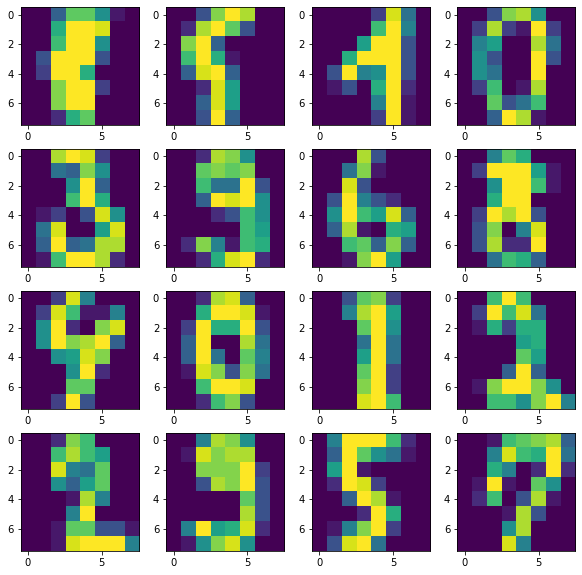

In [53]:
rng = np.random.default_rng()
indices = rng.choice(N, 16)
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digits.images[indices[i], :])
plt.show()

Digits are indeed to be recognized, the hope being that they are linearly separable and we can apply a softmax classifier directly on the pixels. 

The only problem is that each image is a 8x8 matrix, while we want vectors for our model. Fortunately, that is very easy with `reshape`:

In [55]:
X = digits.images.reshape((N, d))

Let's know have a look at the targets, i.e. the ground truth / labels of each digit:

In [54]:
labels = digits.target
print(labels)

[0 1 2 ... 8 9 8]


Each label is an integer between 0 and 9, while our softmax classifier expects a **one-hot-encoded** vector of 10 classes, with only one non-zero element, for example for digit 3:

$$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$$

To do the conversion, we can once again use the built-in method of `scikit-learn`:

In [56]:
from sklearn.preprocessing import OneHotEncoder
t = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()
print(t)
print(t.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(1797, 10)


### Softmax linear classifier

Let's remember the structure of the softmax linear classifier: the input vector $\mathbf{x}$ is transformed into a **logit score** vector $\mathbf{z}$ using a weight matrix $W$ and a bias vector $\mathbf{b}$:

$$
    \mathbf{z} = W \times \mathbf{x} + \mathbf{b}
$$

This logit score has one element per class, so the weight matrix must have a size $(c, d)$, where $c$ is the number of classes (3) and $d$ is the number of dimensions of the input space (2). The bias vector has 3 elements (one per class).

The logit score is turned into probabilities using the **softmax** operation:

$$
    y_j = P(\text{class = j}) = \frac{\exp(z_j)}{\sum_k \exp(z_k)}
$$

The following Python function allows to turn any vector $\mathbf{z}$ (as a numpy array) into softmax probabilities:

In [32]:
def softmax(z):
    e = np.exp(z - z.max())
    return e/np.sum(e)

**Q1:** Experiment with the `softmax()` to understand its function. Pass it different numpy arrays (e.g. [-1, 0, 2]) and print the corresponding probabilities.  

In [33]:
z = np.array([-1, 0, 2])
s = softmax(z)
print(s)

[0.04201007 0.1141952  0.84379473]


The loss function to use is the **cross-entropy** or **negative log-likelihood**, defined for a single example as:

$$
    L(W, \mathbf{b}) =   - < \mathbf{t} . \log \mathbf{y} > = - \log y_j 
$$

where $\mathbf{t}$ is a one-hot encoding of the class of the example and $j$ is the index of the corresponding class (0, 1 or 2).

After doing the derivations, we obtain the following learning rules for $W$ and $\mathbf{b}$ to minimize the loss function:

$$
    \Delta W = \eta \, (\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T
$$

$$
    \Delta \mathbf{b} = \eta \, (\mathbf{t} - \mathbf{y})
$$

Note that because $W$ is a $(c, d)$ matrix, $\Delta W$ too. $(\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T$ is therefore the **outer product** between the error vector $\mathbf{t} - \mathbf{y}$ ($c$ elements) and the input vector $\mathbf{x}$ ($d$ elements).

### Implementation

You will now modify your implementation of the online Perceptron algorithm from last week.

Some things to keep in mind:

* `W` must now be defined as a $(c, d)$ matrix (numpy array) and `b` as a vector with $c$ elements. Both can be initialized to 0.

* When computing the logit score $\mathbf{z} = W \times \mathbf{x} + \mathbf{b}$, remember that `W` is now a matrix, so its position will matter in the dot product `np.dot`.

* Use the `softmax()` function define above instead of `np.sign()` to get the prediction `\mathbf{y}`.

* For $\Delta W$, you will need the **outer** product between the vectors $\mathbf{t} - \mathbf{y}$ and $\mathbf{x}$. Check the doc for `np.outer()`.

* The one-hot encoding of the class of the example $i$ is now a vector with 3 elements `Y[i, :]`. You can get the index of the corresponding class by looking at the position of its maximum with `t[i, :].argmax()`.

* Similarly, the predicted class by the model can be identified by the class with the maximum probability: `y.argmax()`.

* Do not forget to record and plot the evolution of the training error and of the loss function.

**Q:** Let's do it.

Final error: 0.0077907623817473565
Final loss: 0.07258671496001251


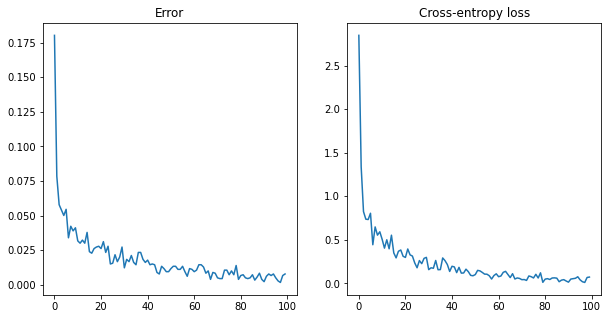

In [44]:
# Parameters
eta = 0.01
nb_epochs = 100

# Initialize the weight matrix and bias vector
W = np.zeros((c, d))
b = np.zeros(c)

# Perceptron algorithm
errors = []
losses = []

for epoch in range(nb_epochs):
    error = 0
    loss = 0.
    
    # Iterate over all training examples
    for i in range(N):
        # Prediction of the hypothesis
        z = np.dot(W, X[i, :]) + b
        
        # Probability
        y = softmax(z)
        
        # Update the weight
        W += eta * np.outer((t[i, :] - y), X[i, :])
        
        # Update the bias
        b += eta * (t[i, :] - y) 
        
        # Increment the error if the maximum probability is different from the class
        if y.argmax() != t[i, :].argmax():
            error += 1
        
        # Accumulate the loss
        loss -= np.log(y[t[i, :].argmax()])
        
    errors.append(error/N)
    losses.append(loss/N)

print("Final error:", error/N)
print("Final loss:", loss/N)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(errors)
plt.title("Error")
plt.subplot(122)
plt.plot(losses)
plt.title("Cross-entropy loss")
plt.show()

**Q:** What is the final training error of the model and the final loss? Is it what you expected? Why do they evolve like this?

**Q:** By looking at the final hyperplanes, do all training examples seem correctly classified? Why does it work anyway?

**Answers:**

Q3: The training error is soon 0, but the loss still decreases for a long number of epochs. This is because the probability vector `y` [0.6, 0.4, 0.4] is a correct prediction for the class 0 (0.6 is the maximum probability), while the target is [1, 0, 0]. The loss continues to evolve even when there is no error, as it wants to bring the probability vector as close as possible to [1, 0, 0].

This is the main difference with the mean square error (mse) loss function: as soon as there are no errors, the mse loss becomes 0 and learning stops. In classification problems, one should therefore track the loss function, not the training error.

Q4: Some points may appear on the wrong side of a single hyperplane, as if they were badly classified (some red points are on the wrong side of the green hyperplane in this example). 

The "green" logit score for these examples is positive, as they are above the hyperplane. However, the "red" logit score will be much higher. The softmax function will in the end attribute a very small probability to the red clas, as the green one will dominate.